First import required packages and functions.

In [1]:
import scipy.io as sio
import numpy as np
from skimage.io import imread
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
from torch.distributions import Normal
from torch import cuda

from tqdm import tqdm_notebook
import copy

# Indiana Pines

Load the data.

In [2]:
def load_data(img_path, target_path, img_dict_el, target_dict_el):
    """Given imformation about the path and the location of the data, loads it and then transforms.
    
    Parameters
    ----------
    img_path: str
        Path to the images.
    target_path: str
        Path to the ground truth labels.
    img_dict_el: str
        Dictionary sell where the images are stored.
    target_dict_el: str
        Dictionary sell where the target labels are stored.
        
    Returns
    -------
    X: numpy.ndarray
        Loaded and transformed images.
    y: numpy.ndarray
        Loaded and transformed for the future convenience labels
    """
    X = sio.loadmat(img_path)[img_dict_el]
    y = sio.loadmat(target_path)[target_dict_el]
    
    for cl in np.unique(y): # See the class labels' distribution.
        print(cl, np.sum(y == cl))
    
    # Shift and scale it so that it will have zero mean and unit standard deviation.
    X = X.transpose((2, 0, 1))
    C, H, W = X.shape
    X = X.reshape(1, C, H, W)
    dataset_mean = X.mean()
    dataset_std = X.std()
    X = (X - dataset_mean) / dataset_std
    y = y.reshape(-1) # repeat y for convenient use of classificator
    return X, y

In [3]:
X, y = load_data('data/Indian_pines_corrected.mat', 'data/Indian_pines_gt.mat', 'indian_pines_corrected', 'indian_pines_gt')

0 10776
1 46
2 1428
3 830
4 237
5 483
6 730
7 28
8 478
9 20
10 972
11 2455
12 593
13 205
14 1265
15 386
16 93


Define encoder and decoder.

In [4]:
use_cuda = False
if (cuda.is_available()):
    use_cuda = True

In [5]:
def train_SVM(features, target, iters=100):
    N, C = features.shape
    SVM = nn.Sequential(nn.BatchNorm1d(num_features=C),
                        nn.Linear(in_features=C, out_features=17))
    if (use_cuda):
        SVM = SVM.cuda()
    loss_function = nn.MultiLabelMarginLoss()
    
    optimizer = optim.SGD(SVM.parameters(), lr=0.01, weight_decay=0.1)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.01)
    
    for it in range(iters):
        scheduler.step()
        
        scores = SVM(features)
        loss = loss_function(scores, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return SVM
    
def train_ANN(features, target, iters=100):
    N, C = features.shape
    NN = nn.Sequential(nn.BatchNorm1d(num_features=C),
                       nn.Linear(in_features=C, out_features=1000),
                       nn.ReLU(),
                       nn.Linear(in_features=1000, out_features=17))
    if (use_cuda):
        NN = NN.cuda()
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(NN.parameters(), lr=0.01, weight_decay=0.5)
    
    for it in range(iters):
        scores = NN(features)
        loss = loss_function(scores, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    
    
    return NN

def pred_class(classifier, features):
#     classifier.
    scores = classifier(features)
    if (use_cuda):
        result = torch.max(scores, dim=1)[1].data.cpu().numpy()
    else:
        result = torch.max(scores, dim=1)[1].data.numpy()
    return result

In [6]:
def get_classification_performance(encoder, img, y):
    """Gets dataset, splits it to the training and validation set, 
    fits LogisticRegression(ANN) and returns misclassified pixels percentage.
    
    Parameters
    ----------
    img: torch.autograd.Variable
        Dataset.
    y: numpy.ndarray
        Ground truth labels of the given dataset.
        
    Returns
    -------
    error: float
        Misclassification of pixels percentage.
    """
    
    encoder.eval()

    features_raw = encoder(img) # get encoder output
    features_raw = copy.deepcopy(features_raw.data)

    # flatten and split to the training and validation parts to fit LogisticRegression(ANN) on this data
    N, C, H, W = features_raw.shape    
    features = torch.transpose(features_raw.view(C, -1), 1, 0) # note that N is always equal to 1
    features = Variable(features, requires_grad=False)
    
    target_oh = torch.zeros(H*W, 17)
    target_oh = Variable(target_oh.scatter_(1, torch.LongTensor(y.reshape(-1, 1)), 1).long(), requires_grad=False)
    target = Variable(torch.LongTensor(y), requires_grad=False)
    if (use_cuda):
        features_numpy = features_raw.view(C, -1).cpu().numpy()
        target = target.cuda()
        target_oh = target_oh.cuda()
    else:
        features_numpy = features_raw.view(C, -1).numpy()
    features_numpy = features_numpy.T
    
    # perform cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # 10 folds
    scores_train_knn = []
    scores_test_knn = []
    scores_train_svm = []
    scores_test_svm = []
    scores_train_logreg = []
    scores_test_logreg = []
    scores_train_ann = []
    scores_test_ann = []
    for train_indices, test_indices in skf.split(features_numpy, y):
        
#         kNN
        knn = KNeighborsClassifier()
        knn.fit(features_numpy[train_indices], y[train_indices])
        train_acc_knn = accuracy_score(y[train_indices], knn.predict(features_numpy[train_indices]))
        test_acc_knn = accuracy_score(y[test_indices], knn.predict(features_numpy[test_indices]))
        scores_train_knn.append(train_acc_knn)
        scores_test_knn.append(test_acc_knn)
        
        train_indices_torch = torch.LongTensor(train_indices)
        test_indices_torch = torch.LongTensor(test_indices)
        if (use_cuda):
            train_indices_torch = train_indices_torch.cuda()
            test_indices_torch = test_indices_torch.cuda()
        
#         SVM
        svm = train_SVM(features[train_indices_torch], target_oh[train_indices_torch], iters=200)
        svm.eval()
        train_acc_svm = accuracy_score(y[train_indices], pred_class(svm, features[train_indices_torch]))
        test_acc_svm = accuracy_score(y[test_indices], pred_class(svm, features[test_indices_torch]))
        scores_train_svm.append(train_acc_svm)
        scores_test_svm.append(test_acc_svm)
        
        #logreg
        logreg = LogisticRegression()
        logreg.fit(features_numpy[train_indices], y[train_indices])
        train_acc_logreg = accuracy_score(y[train_indices], logreg.predict(features_numpy[train_indices]))
        test_acc_logreg = accuracy_score(y[test_indices], logreg.predict(features_numpy[test_indices]))
        scores_train_logreg.append(train_acc_logreg)
        scores_test_logreg.append(test_acc_logreg)
        
        # ANN
        ann = train_ANN(features[train_indices_torch], target[train_indices_torch])
        ann.eval()
        train_acc_ann = accuracy_score(y[train_indices], pred_class(ann, features[train_indices_torch]))
        test_acc_ann = accuracy_score(y[test_indices], pred_class(ann, features[test_indices_torch]))
        scores_train_ann.append(train_acc_ann)
        scores_test_ann.append(test_acc_ann)
    
    acc_train_knn = np.mean(scores_train_knn)
    acc_test_knn = np.mean(scores_test_knn)
    acc_train_svm = np.mean(scores_train_svm)
    acc_test_svm = np.mean(scores_test_svm)
    acc_train_logreg = np.mean(scores_train_ann)
    acc_test_logreg = np.mean(scores_test_ann)
    acc_train_ann = np.mean(scores_train_ann)
    acc_test_ann = np.mean(scores_test_ann)
    
    encoder.train()
    return acc_test_knn, acc_test_svm, acc_test_logreg, acc_test_ann

In [7]:
def init_autoencoder(X, in_channels=200, lr=0.001, reg=0):
    encoder = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=100, kernel_size=5, padding=2),
                        nn.ReLU(),
                        nn.BatchNorm2d(num_features=100),
                        nn.Conv2d(in_channels=100, out_channels=50, kernel_size=3, padding=1),
                        nn.ReLU(), 
                        nn.BatchNorm2d(num_features=50),
                        nn.Conv2d(in_channels=50, out_channels=25, kernel_size=1),
                        nn.BatchNorm2d(num_features=25))
    decoder = nn.Sequential(nn.ConvTranspose2d(in_channels=25, out_channels=50, kernel_size=1), 
                            nn.BatchNorm2d(num_features=50),
                            nn.ConvTranspose2d(in_channels=50, out_channels=100, kernel_size=3, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(num_features=100),
                            nn.ConvTranspose2d(in_channels=100, out_channels=in_channels, kernel_size=5, padding=2),
                            nn.ReLU())
    
    # define loss as MSE and optimization method as Adam. Also convert the dataset to the PyTorch format
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001, weight_decay=reg)
    img = Variable(torch.FloatTensor(X.copy()))
    if (use_cuda):
        encoder = encoder.cuda()
        decoder = decoder.cuda()
        img = img.cuda()
    return (encoder, decoder, optimizer, loss_function), img

In [8]:
def train_autoencoder(model, img, y, epochs=5):
    """Trains defined globally called encoder-decoder network.
    
    Parameters
    ----------
    img: torch.autograd.Variable.
        Dataset to train the net
    epochs: int, default: 5
        Number of passes through the full dataset.
    y: numpy.ndarray
        Ground truth labels of the given dataset. Used to check classification performance
        
    Returns
    -------
    loss: float
        Result loss value.
    losses: list
        Losses history for each epoch.
    """
    encoder, decoder, optimizer, loss_function = model
    
    performance_train = []
    performance_test = []
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad() # set gradient values to zero. Just PyTorch stuff
        encoder_out = encoder(img) # get encoded image
        decoder_out = decoder(encoder_out) # and then decode it
        loss = loss_function(decoder_out, img) # calculate the loss value
        if (use_cuda):
            losses.append(loss.data.cpu().numpy().copy()[0])
        else:
            losses.append(loss.data.numpy().copy()[0])
        loss.backward() # and compute gradients
        optimizer.step() # make optimization step
    
        clear_output()
        plt.plot(losses, label="Loss")
        plt.xlim([0, epochs - 1])
        plt.legend()
        plt.show()
        
    encoder_out = encoder(img)
    decoder_out = decoder(encoder_out)
    loss = loss_function(decoder_out, img)
    return loss, losses#, performance_train, performance_test

def plt_map(act_map):
    """Plots given activation map of the convolution layer.
    
    Parameters
    ----------
    act_map: torch.autograd.Variable
        Activation map which will be plotted
    """
    N = act_map.data.shape[0]
    if (use_cuda):
        act_map = act_map.cpu()
    
    plt.figure(figsize=(10, 10))
    _, axes = plt.subplots(N // 10 + int(N % 10), 10)
    for ax in axes.reshape(-1):
        ax.axis('off')
    for i, filter_ in enumerate(act_map.data.numpy()):
        axes[i // 10, i % 10].imshow(filter_);
        
def get_and_plot_act_map(encoder, img):
    """Extracts layer and it's activation map passed one image.
    
    Parameters
    ----------
    img: torch.autograd.Variable
        Dataset.
        
    Returns:
    activations: torch.autograd.Variable
        activation map on the first convolutional layer.
    """
    
    _, first_layer = list(encoder._modules.items())[0] # get networks' first layer 
    activations = first_layer(img) # and get activation values
    plt_map(activations.squeeze())
    return activations

Train the model.

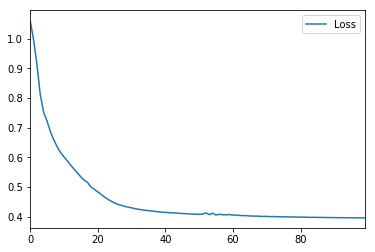

Variable containing:
 0.3954
[torch.cuda.FloatTensor of size 1 (GPU 0)]



<Figure size 720x720 with 0 Axes>

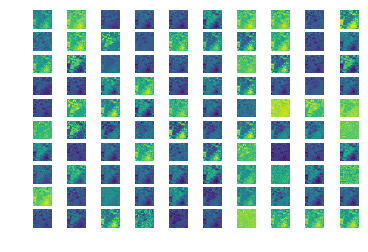

In [9]:
model, img = init_autoencoder(X)
reconstruction_error, losses = train_autoencoder(model, img, y, 100)
activations = get_and_plot_act_map(model[0], img) # save activations of the first convolutional layer
print(reconstruction_error)

In [10]:
%%time
encoder = model[0]
print(get_classification_performance(encoder, img, y))

(0.7852605229864691, 0.5068851027372886, 0.5125353392607017, 0.5125353392607017)
CPU times: user 3min 27s, sys: 59.4 s, total: 4min 27s
Wall time: 4min 27s


# Salinas-A

Now let's fine-tune autoencoder and classifier to check their performance on the Salinas-A dataset.

In [11]:
X, y = load_data('data/SalinasA_corrected.mat', 'data/SalinasA_gt.mat', 'salinasA_corrected', 'salinasA_gt')
img = Variable(torch.FloatTensor(X.copy()))

0 1790
1 391
10 1343
11 616
12 1525
13 674
14 799


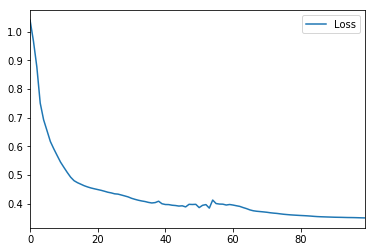

Variable containing:
 0.3494
[torch.cuda.FloatTensor of size 1 (GPU 0)]



<Figure size 720x720 with 0 Axes>

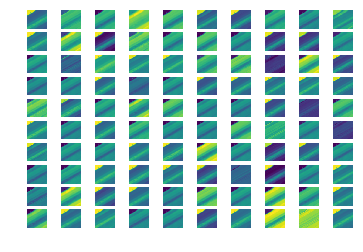

In [12]:
model, img = init_autoencoder(X, in_channels=204)
reconstruction_error, losses_salinas, = train_autoencoder(model, img, y, epochs=100)
activations = get_and_plot_act_map(model[0], img)
print(reconstruction_error)

In [13]:
encoder = model[0]
get_classification_performance(encoder, img, y)

(0.9441007312907773,
 0.2493697454358367,
 0.2507724719182155,
 0.2507724719182155)

# Conclusion
Linear models are giving less performance as number of epochs to train autoencoder increases. That may be caused by creating more complex representation. i.e. better it copies the image, more complex information is saved in the encoder result. Also ANN is not doing well. The reason may be the same. It's hard to train it on that complex representation.